In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

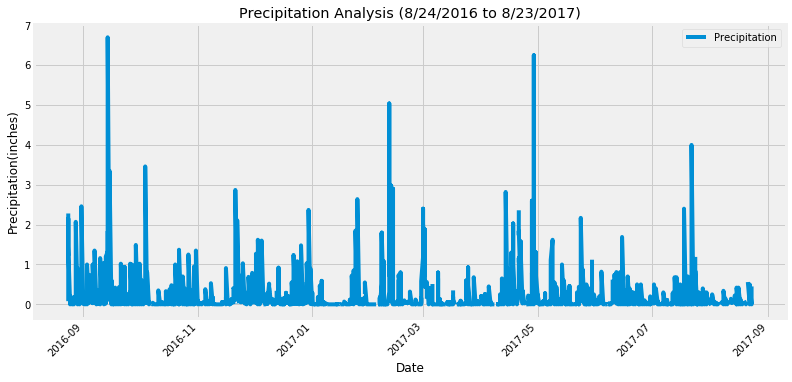

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Get the date a year from the last date.
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Calculate the date 1 year ago from the last data point in the database
one_yr_prcp = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_date).\
                        order_by(Measurement.date).all()

# Perform a query to retrieve the data and precipitation scores
precipitation_df = pd.DataFrame(one_yr_prcp, columns=['Date', 'Prcp'])
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y/%m/%d')

# Sort the dataframe by date
precipitation_df.set_index(precipitation_df['Date'], inplace=True)
precipitation_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot('Date', 'Prcp',figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [11]:
# Summary statistics for the percipitation df. 
precipitation_df.describe()


,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### The above data is the recorded precipitation from each weather station for each date. It will be shown in the next graph

In [12]:
# Load the results into a pandas dataframe.

precipitation_sum = pd.DataFrame(one_yr_prcp, columns=['Date', 'Prcp'])

#Change the date to a datetime format.
precipitation_sum['Date'] = pd.to_datetime(precipitation_sum['Date'], format='%Y/%m/%d')

#precipitation_df.set_index('Date').head()
# Get the total for each station for each date and set the index as the date.
precipitation_totals = precipitation_sum.pivot_table(precipitation_sum, index=['Date'], aggfunc='mean')
precipitation_totals.head()


,Prcp
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


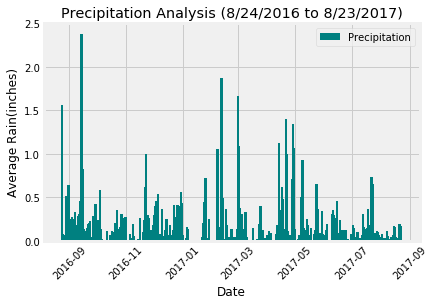

In [13]:
# Plot the dataframe as a horizontal bar chart using pandas plotting

plt.bar(precipitation_totals.index, precipitation_totals["Prcp"], width=2.5, color="teal")
plt.rcParams["figure.figsize"] = [12,6]
plt.xlabel("Date")
plt.ylabel("Average Rain(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [14]:
# Summary statistics for the percipitation df. 
precipitation_totals.describe()

,Prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print("There are {} stations.".format(station_count))




There are 9 stations.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# List the most active stations and their observation counts in descending order.
engine.execute('SELECT m.station, count(m.id) FROM Measurement m GROUP BY m.station ORDER BY 2 DESC').fetchall()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f'For Station {temps[0][0]} the highest temp recorded was {temps[0][1]} degrees, the lowest temp recorded was {temps[0][2]} degrees, and the average temp was {round(temps[0][3])}.')

For Station USC00519281 the highest temp recorded was 85.0 degrees, the lowest temp recorded was 54.0 degrees, and the average temp was 72.


In [20]:
# Choose the station with the highest number of temperature observations.
highest_obs = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
obs_df = pd.DataFrame(highest_obs)
obs_df.head(3)



,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0


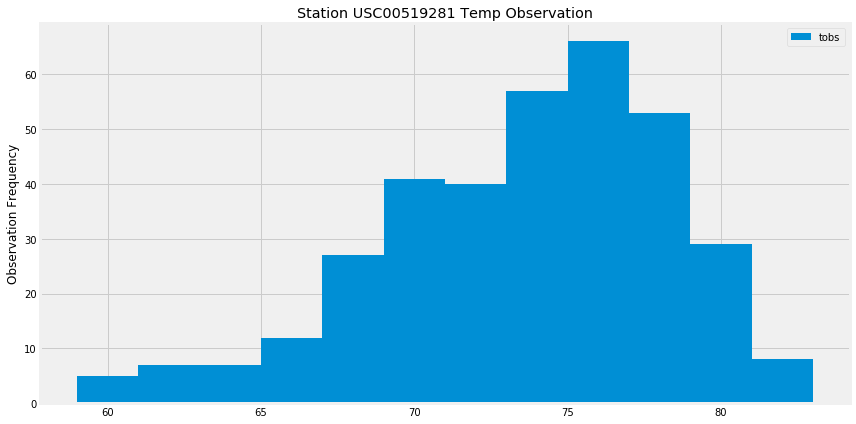

In [21]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
obs_df.plot.hist(bins=12)
plt.ylabel("Observation Frequency")
plt.title("Station USC00519281 Temp Observation")
plt.tight_layout()
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    for Tmin, Tmax, Tavg in query:
        print("From", start_date, "to", end_date, "the minimum temperature is",
              Tmin,'\u00b0'"F, the maximum temperature is", Tmax,'\u00b0'"F, and the average temeperature is",
              "{0:.1f}".format(round(Tavg,1)),'\u00b0'"F.")

calc_temps('2017-06-28', '2017-07-07')


From 2017-06-28 to 2017-07-07 the minimum temperature is 74.0 °F, the maximum temperature is 87.0 °F, and the average temeperature is 77.7 °F.


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-06-28'
end_date = '2017-07-07'
vacay_query = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# Load the results into a pandas dataframe.

vacay_temps = pd.DataFrame(vacay_query, columns=['Date', 'Tobs'])
vacay_temps.head()

,Date,Tobs
0,2017-06-28,79.0
1,2017-06-29,79.0
2,2017-06-30,75.0
3,2017-07-01,80.0
4,2017-07-02,80.0


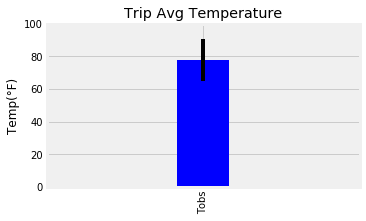

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = vacay_temps.mean()
temp_diff = (vacay_temps["Tobs"].max()-vacay_temps["Tobs"].min())


p = avg_temp.plot(legend=False,kind="bar",color="blue",yerr=temp_diff, width=0.1, figsize=(5,3))
p.set_title("Trip Avg Temperature")
p.set_ylabel("Temp(°F)")
p.set_ylim(0,100)
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
